# STAT 201 Project Proposal

## A Look into Salaries and Remote Work in the Data Science Field

### Ryan Arnouk, Amy Chen, Reuben John, Youssef Saleh

## Introduction

### Background

Monetary compensation is a one of the key factors in employee satisfaction (Card et al., 2012), and studies have shown that working remotely has also positively impacted satisfaction during the pandemic, due to increased autonomy (Galanti et al., 2021).

Based on these two facts, this report aims to provide information regarding salaries and the likelihood of working remotely for each type of job, to people entering the data science job market. This would help them find jobs that match their own hopes and aspirations, as well as create a work environment that is productive in and out of the workplace by influencing work-life balance.

### Guiding Question
> Comparing full-time Data Analysts and Data Engineers, is there a *difference in means* of salaries and *difference in proportions* of remote work?

### Dataset

In this project, we use the dataset, "Data Science Job Salaries", by Ruchi Bhatia (2022) from [Kaggle](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries). It contains both qualitative and quantitative observations we can harness, like the year the salary was paid, experience level, employment type, title, salary, remote ratio, company size, and company location.

From this dataset, our variables of interest are as follows:
* ```salary_in_usd``` is our response variable, it uses a single currency (USD) to make comparisons easier regardless of country.
* ```job_title``` is one of our explanatory variables; a ```chr``` describing each employee's profession.
* ```remote_ratio``` is another explanatory variable; a ```fct``` describing each employee's ratio of remote work (0 = less than 20%, 50 = in between, 100 = greater than 80%)

While ```experience_level``` does affect salary, this project is aimed at helping potential employees choose a job, and their own experience level is not something they can select for when job hunting.

Together, these variables can help us achieve a more complete picture of the job market in the Data Science field.

## Preliminary Results

### Reading the Data

Kaggle does not allow datasets to be read directly from the website, so we downloaded the data to our repository and read it from there.

In [1]:
library(tidyverse)
library(infer)
library(broom)
library(gridExtra)
library(scales)

set.seed(1234)

# reading the data
salaries <- read.csv("https://raw.githubusercontent.com/ryanarnouk/stat-201-project/main/ds_salaries.csv") %>%
     select(!X) # index column

# preview the data
head(salaries)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
2,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
3,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
4,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
5,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
6,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


### Cleaning and Wrangling Data

This dataset contains a lot of ```job_title``` categories, so let's see which ones we can work with.

In [2]:
# calculating the number of employees in each job title category
salaries %>% 
    filter(employment_type == "FT") %>% # filtering for full-time employees
    group_by(job_title) %>%
    summarise(n = n()) %>%
    arrange(-n) %>% # so most frequent jobs come up first
    head()

job_title,n
<chr>,<int>
Data Scientist,140
Data Engineer,129
Data Analyst,96
Machine Learning Engineer,41
Research Scientist,16
Data Science Manager,12


Here we can see that the first three categories each have more than 30 observations, meaning they are large enough, and are similar in size. Of those three, Data Scientist is a very broad job definition, so we will compare Data Engineers and Data Analysts.

Let's grab only those categories and store them in a dataframe named ```top_jobs```.

In [3]:
# filtering for full-time employees from both categories
data_jobs <- salaries %>%
    filter(employment_type == "FT",
           job_title %in% c("Data Engineer", "Data Analyst")) %>%
    mutate(remote_ratio = recode(remote_ratio, `0` = "in_person", `50` = "hybrid", `100` = "remote"),
          is_remote = remote_ratio == "remote") %>%
    select(job_title, is_remote, salary_in_usd) # more readable

head(data_jobs)

,job_title,is_remote,salary_in_usd
,<chr>,<lgl>,<int>
1,Data Analyst,TRUE,72000
2,Data Analyst,TRUE,85000
3,Data Analyst,FALSE,8000
4,Data Engineer,TRUE,41689
5,Data Engineer,FALSE,47899
6,Data Engineer,FALSE,33511


### Plots

#### Salary distributions

First, let's look at the distributions of salaries in each of the categories by plotting them side-by-side.
We will also add red vertical lines to show their mean salaries.

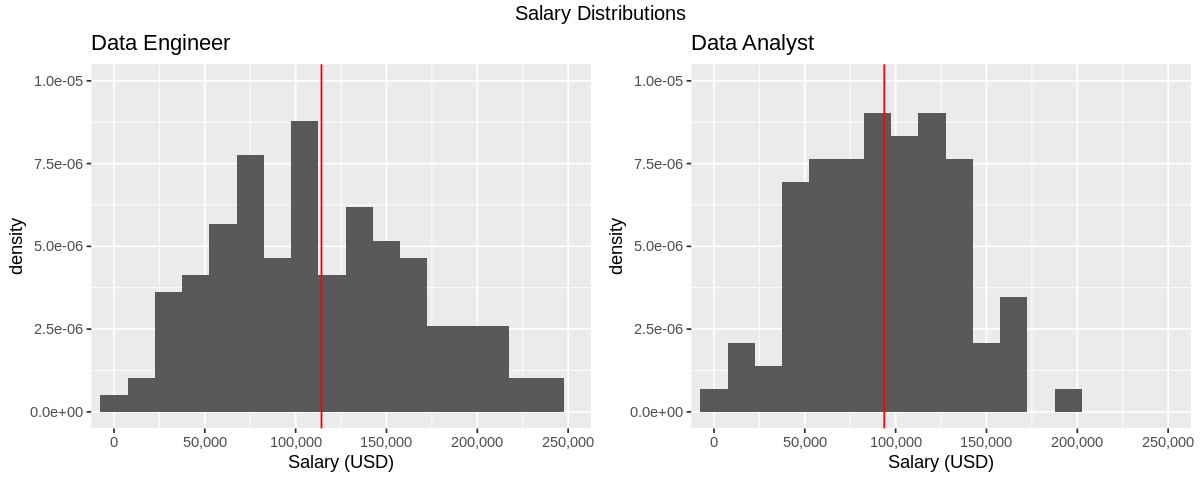

In [4]:
options(repr.plot.width = 10, repr.plot.height = 4) # setting dimensions

engr_dist <- data_jobs %>% # data engineer distribution
    filter(job_title == "Data Engineer") %>%
    ggplot(aes(x = salary_in_usd, y = ..density..)) +
    geom_histogram(binwidth = 15000) +
    geom_vline(xintercept = mean(filter(data_jobs, job_title == "Data Engineer")$salary_in_usd),
              color = "red") +
    labs(x = "Salary (USD)", title = "Data Engineer") +
    scale_x_continuous(labels = comma) +  # so salaries aren't in scientific notation
    coord_cartesian(xlim = c(0, 250000), ylim = c(0, 1e-05)) # same width x-axes
                                                                # this cuts off some outlier data

anst_dist <- data_jobs %>% # data analyst distribution
    filter(job_title == "Data Analyst") %>%
    ggplot(aes(x = salary_in_usd, y = ..density..)) +
    geom_histogram(binwidth = 15000) +
    geom_vline(xintercept = mean(filter(data_jobs, job_title == "Data Analyst")$salary_in_usd),
              color = "red") +
    labs(x = "Salary (USD)", title = "Data Analyst") +
    scale_x_continuous(labels = comma) + # so salaries aren't in scientific notation
    coord_cartesian(xlim = c(0, 250000), ylim = c(0, 1e-05)) # same width x-axes

grid.arrange(engr_dist, anst_dist, ncol = 2, top = "Salary Distributions")

### Estimates

Before testing our hypotheses, we need to have the appropriate point estimates.

In [52]:
data_estimates <- data_jobs %>%
    group_by(job_title) %>%
    summarize(n = n(), # number of observations
              salary_mean = mean(salary_in_usd), # mean salary
              salary_sd = sd(salary_in_usd), # standard deviation of salaries
              remote_prop = mean(is_remote),  # proportion of remote work
              remote_sd = sqrt(remote_prop * (1 - remote_prop))) # standard deviation of remote work

head(data_estimates)

job_title,n,salary_mean,salary_sd,remote_prop,remote_sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Data Analyst,96,93752.84,39258.60,0.7291667,0.4443902
Data Engineer,129,114224.82,57349.85,0.7131783,0.4522776


**Note**: Although the median is a better estimate for salaries, this project relies on CLT, which dictates that we use the mean instead.

## Methods

### Plan

So far, this report has indicated that the mean salaries earned by Data Engineers and Data Analysts are different, as well as their proportion of employees working remotely. We used representative samples (with n > 30), and have narrowed it down to full-time employees, so that the response variables are truly random and not based on employment type.

Unfortunately, our plots and point estimates are not enough to prove that. Because they use only one sample, they are more prone to error compared to a *sampling* distribution, so to remedy this, we will use resampling and asymptotic methods to model the population distributions.

Since we do not have the populations' true means $\mu$, proportions $p$, and standard deviations $\sigma$, we will use the sample means $\bar{x}$, proportions $\hat{p}$, and standard deviations $s$. To account for the risk of error associated with this substitution, we will use $t$-distributions because of their thicker tails and wider spread, as compared to a standard distribution.

We will also perform bootstrapping on both samples, generating a sampling distribution of salary standard deviations and proportion of remote work standard deviations for each sample.

By letting Data Engineers be population 1, and Data Analysts be population 2, we aim to test the following hypotheses:

for the mean salary:
$$H_0 : \mu_1 - \mu_2 = 0$$
$$H_1 : \mu_1 - \mu_2 \neq 0$$

for the proportion of remote work:
$$H_0 : p_1 - p_2 = 0$$
$$H_1 : p_1 - p_2 \neq 0$$

where $\mu$ is the population's mean salary and $p$ is its proportion of employees working remotely. Our $t$-distributions will therefore be $t_{128}$ and $t_{95}$ respectively.

We expect to reject both null hypotheses under a 5% significance level, with a 90% confidence level.

## Results

### Comparing standard deviations

To compare the distribution of salaries between the two jobs, we need to estimate the standard deviation.

Since we do not have the actual population standard deviation $\sigma$, we need to use bootstrapping to generate a sampling distribution of standard deviations.

First, we will generate 10000 bootstrap replicates with replacement, then group by `replicate` and `job_title`, then calculate the standard deviations of both of `salary_in_usd` and `is_remote`.

In [53]:
set.seed(1234)

bootstrap <- data_jobs %>%
    rep_sample_n(size = nrow(data_jobs), reps = 10000, replace = TRUE) %>%
    group_by(replicate, job_title) %>%
    summarize(salary_sd = sd(salary_in_usd), 
              remote_sd = sqrt(mean(is_remote) * (1 - mean(is_remote))))

head(bootstrap)

`summarise()` has grouped output by 'replicate'. You can override using the
`.groups` argument.


replicate,job_title,salary_sd,remote_sd
<int>,<chr>,<dbl>,<dbl>
1,Data Analyst,41794.49,0.4149559
1,Data Engineer,58474.52,0.4307692
2,Data Analyst,39898.16,0.4268292
2,Data Engineer,56382.87,0.4446397
3,Data Analyst,37217.73,0.4346591
3,Data Engineer,53413.25,0.4502677


Second, we need to get the 90% confidence intervals for each statistic

In [54]:
salary_sd_ci <- bootstrap %>%
    group_by(job_title) %>%
    summarize(lower_ci = quantile(salary_sd, 0.05), 
              upper_ci = quantile(salary_sd, 0.95))

remote_sd_ci <- bootstrap %>%
    group_by(job_title) %>%
    summarize(lower_ci = quantile(remote_sd, 0.05), 
              upper_ci = quantile(remote_sd, 0.95))

salary_sd_ci
remote_sd_ci

job_title,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Data Analyst,34584.90,43503.92
Data Engineer,50789.68,63558.73


job_title,lower_ci,upper_ci
<chr>,<dbl>,<dbl>
Data Analyst,0.3981362,0.4764363
Data Engineer,0.4151696,0.4778914


From simply looking at the numbers, we can deduce the following:
1. Data Engineer salaries are more varied (approx. 51000 - 64000, 90% conf.) than Data Analysts (approx. 35000 - 44000, 90% conf.)
2. Data Engineer remote work proportions are around the same as those of Data Analysts.

Just to be sure, however, let's visualize the two distribitions

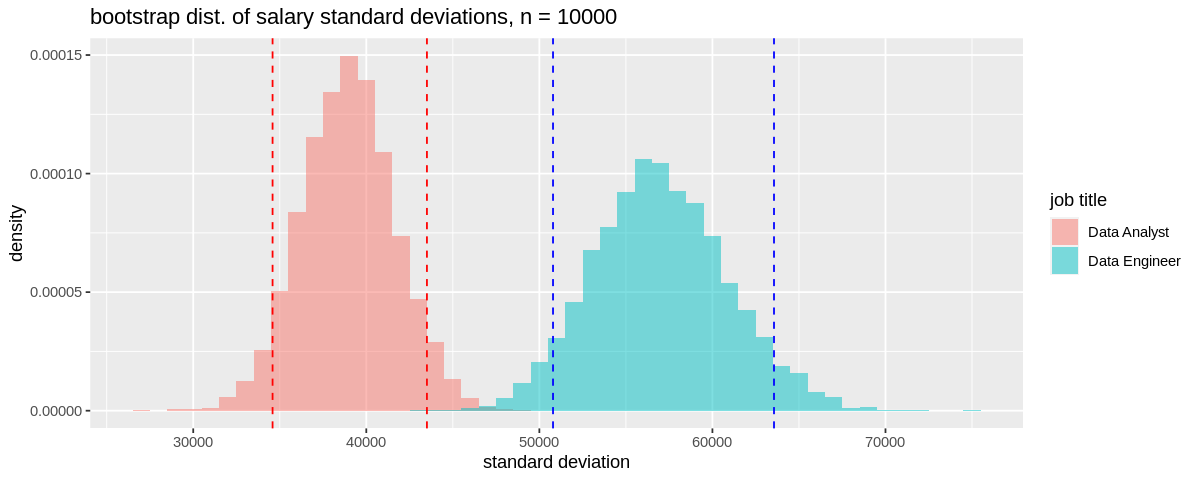

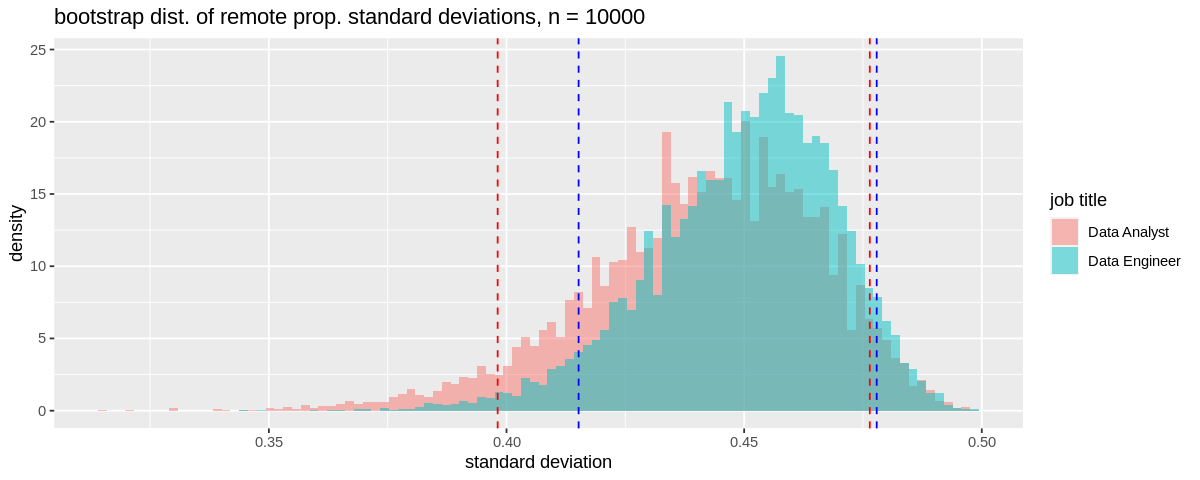

In [55]:
bootstrap_salary_sd_dist <- bootstrap %>%
    ggplot(aes(x = salary_sd, y = ..density.., fill = job_title)) +
    geom_histogram(binwidth = 1000, position = "identity", alpha = 0.5) +
    geom_vline(xintercept = c(salary_sd_ci$lower_ci[1], salary_sd_ci$upper_ci[1]), color = "red", linetype = "dashed") +
    geom_vline(xintercept = c(salary_sd_ci$lower_ci[2], salary_sd_ci$upper_ci[2]), color = "blue", linetype = "dashed") +
    labs(x = "standard deviation", fill = "job title", title = "bootstrap dist. of salary standard deviations, n = 10000")

bootstrap_remote_sd_dist <- bootstrap %>%
    ggplot(aes(x = remote_sd, y = ..density.., fill = job_title)) +
    geom_histogram(bins = 100, position = "identity", alpha = 0.5) +
    geom_vline(xintercept = c(remote_sd_ci$lower_ci[1], remote_sd_ci$upper_ci[1]), color = "red", linetype = "dashed") +
    geom_vline(xintercept = c(remote_sd_ci$lower_ci[2], remote_sd_ci$upper_ci[2]), color = "blue", linetype = "dashed") +
    labs(x = "standard deviation", fill = "job title", title = "bootstrap dist. of remote prop. standard deviations, n = 10000")

bootstrap_salary_sd_dist
bootstrap_remote_sd_dist

Just as suspected, there is a clear and distinct difference between the salary standard deviations, with Data Engineers significantly higher. On the other hand, the remote proportion standard deviations are almost identical, with Data Engineers only slightly edging out Data Analysts.

### Difference in means, proportions

To test our hypotheses and get the differences in salary means and remote work proportions, we will use the `pt` and `qt` functions to calculate our $p$-values and confidence intervals.

Then, just to be sure, we will be running $t$-tests for each of the null hypotheses, using the `t.test` function.

First, to remind ourselves of the point estimates

In [56]:
data_estimates

job_title,n,salary_mean,salary_sd,remote_prop,remote_sd
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Data Analyst,96,93752.84,39258.60,0.7291667,0.4443902
Data Engineer,129,114224.82,57349.85,0.7131783,0.4522776


Now, calculating the $p$-value and confidence interval for the difference in salary means:

In [78]:
de = data_estimates

mean_t_stat <- (de$salary_mean[2] - de$salary_mean[1])/sqrt(de$salary_sd[2]^2/de$n[2] + de$salary_sd[1]^2/de$n[1])

mean_p_val <- 2 * pt(mean_t_stat, df = 224, lower.tail = FALSE) # since x1 > x2

mean_ci <- tibble(mean_lower_ci = de$salary_mean[2] - de$salary_mean[1]
                                  + qt(0.05, df = 224) * sqrt(de$salary_sd[2]^2/de$n[2] + de$salary_sd[1]^2/de$n[1]), 
                  mean_upper_ci = de$salary_mean[2] - de$salary_mean[1]
                                  + qt(0.95, df = 224) * sqrt(de$salary_sd[2]^2/de$n[2] + de$salary_sd[1]^2/de$n[1]))

tibble(mean_p_val, mean_ci)

mean_p_val,mean_lower_ci,mean_upper_ci
<dbl>,<dbl>,<dbl>
0.001703775,9825.244,31118.71


Based on the $p$-value of 0.17%, and given a significance level of 5%, we **have enough evidence to reject $H_0$**, and can be 90% confident that, on average, Data Engineers earn around \\$9800 to \\$31000 more than Data Analysts.

And for the difference in remote work proportions:

In [76]:
de = data_estimates

phat <- (de$remote_prop[1]*de$n[1] + de$remote_prop[2]*de$n[2]) / (de$n[1] + de$n[2])

remote_t_stat <- (de$remote_prop[2] - de$remote_prop[1])/ sqrt(phat * (1 - phat) * (1/de$n[1] + 1/de$n[2]))

remote_p_val <- 2 * pt(remote_t_stat, df = 224, lower.tail = TRUE) # since p2 > p1

remote_ci <- tibble(prop_lower_ci = de$remote_prop[2] - de$remote_prop[1]
                                  + qt(0.05, df = 224) * sqrt(phat * (1 - phat) * (1/de$n[1] + 1/de$n[2])), 
                    prop_upper_ci = de$remote_prop[2] - de$remote_prop[1]
                                  + qt(0.95, df = 224) * sqrt(phat * (1 - phat) * (1/de$n[1] + 1/de$n[2])))

tibble(remote_p_val, remote_ci)

remote_p_val,prop_lower_ci,prop_upper_ci
<dbl>,<dbl>,<dbl>
0.7918849,-0.11595,0.08397322


Based on the $p$-value of 79%, and given a significance level of 5%, we **do not have enough evidence to reject $H_0$**, and cannot claim a difference in the proportions of employees working remotely.

Just to be sure, we will also run a couple of `t.test` functions

In [16]:
mean_t_test <- t.test(x = filter(data_jobs, job_title == "Data Engineer")$salary_in_usd,
           y = filter(data_jobs, job_title == "Data Analyst")$salary_in_usd, 
           alternative = "two.sided", paired = FALSE, conf.level = 0.90) %>%
    tidy() %>%
    select(p.value, conf.low, conf.high)

mean_t_test

p.value,conf.low,conf.high
<dbl>,<dbl>,<dbl>
0.001706161,9824.761,31119.2


In [10]:
prop_t_test <- t.test(x = filter(data_jobs, job_title == "Data Engineer")$is_remote,
           y = filter(data_jobs, job_title == "Data Analyst")$is_remote, 
           alternative = "two.sided", paired = FALSE, conf.level = 0.90) %>%
    tidy() %>%
    select(p.value, conf.low, conf.high)

prop_t_test

p.value,conf.low,conf.high
<dbl>,<dbl>,<dbl>
0.7922944,-0.1161767,0.08419995


These results are almost equal to the previous ones, so we can rest easy.

## Discussion

### Connection back to main question/goal
Connecting our results back to our main goal, we find that with a 5% significance level, we have no evidence that data analysts and data engineers have the mean salary (and we instead favour the alternative hypothesis that there exists a difference in means between data engineers and data analysts). This is further supported by a 90% confidence interval calculated to show... TODO

### Summary

### Expectations vs. Findings

### Impact

These findings could impact how new data science graduates choose what jobs to apply for, as well as what specific career paths undergraduates may wish to focus on. In the data science field, data analysts and data engineers are very popular career choices. Undergraduates others entering the job market may be interested in figures that can help decide which path is a better choice.  

Moreover, analysis of the industry can be conducted and compared to other industries. Creating open dialogues through concrete evidence is important for innovation and we hope that our work can be used as a metric that can facilitate such discussions to create a more holistic view of the current job market in the data science and statistics field.   

### Future

This opens the door for further questions about the difference in experience level, company location and company size when comparing different job titles within the Data Science field. Also, with more data, these questions can be answered for the rest of the jobs that we could not examine due to their sample sizes and distributions.

We hope further research can be conducted comparing different variables further along with assessment on how salary impacts wellbeing and job satisfaction for both parties (the employer and employee) and along multiple industries.

Furthermore, we hope that research can be conducted with demographical datasets comparing who is actually working within these roles. For example one potential question that can be answered with statistical inference is if there is a difference in means/median salary from males/females or certain socioeconimic background and factors. The range of questions can be further spread and answers within different disciplines to help employees and employers make smarter decisions, to create a better professional world.


## References

Bhatia, R. (2022). *Data science job salaries*. \[Dataset\] https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries

Card, D., Mas, A., Moretti, E., & Saez, E. (2012). Inequality at work: The effect of peer salaries on job satisfaction. *American Economic Review*, 102(6), 2981–3003. https://doi.org/10.1257/aer.102.6.2981

Galanti, T., Guidetti, G., Mazzei, E., Zappalà, S., & Toscano, F. (2021). Work from home during the COVID-19 outbreak: the impact on employees' remote work productivity, engagement, and stress. *Journal of Occupational and Environmental Medicine*, 63(7), e426–e432. https://doi.org/10.1097/JOM.0000000000002236